<a href="https://colab.research.google.com/github/Ansi4Ansi/Google_colab/blob/main/ML_B2C_2024_Q2_%7C_HW08_ML_generative_ai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework #8: Генеративный ИИ

**Оформление ДЗ**:

- Выполненное ДЗ сохраните в файл ``ml_b2c2024q2_<Surname>_<Name>_HW#.ipynb``
  
  (пример ``ml_b2c2024q2__Dral_Alexey_HW01.ipynb``)
- Зарегистрироваться и залогиниться в сервисе [Everest](https://everest.distcomp.org/)
- Перейти на страницу приложения: [BDT-grader-ML-B2C](https://everest.distcomp.org/apps/BigDataTeam/BDT-grader-ML-B2C)
- Выбрать вкладку Submit Job (если отображается иная).
- Выбрать в качестве “Task” значение: `` ML_generative_ai`` (кодовое название для преподвателей: `` ML_generative_ai``)
- Загрузить в качестве “Task solution” файл с решением
- В качестве Access Token указать тот, который был выслан по почте или в телеграм от аккаунта @bdt_manager

**Дополнительные ссылки**
- Настройка локального окружения: https://github.com/big-data-team/ml-course
- Датасеты UCI: https://archive.ics.uci.edu/

**Вопросы**:
- Свои вопросы присылайте в Телеграм.

**Фидбек**:
- Пожалуйста, оставьте свой отзыв после выполнения домашнего задания по сссылке:

    https://forms.gle/iY5NRn9UfaZ344rbA

## Вопросы на понимание (10%)

1. Почему в автоэнкодерах не обязательно использование валидационной выборки?
2. Что произойдет с вариативным автоэнкодером, если убрать регуляризацию через KL-дивергенцию?
3. Допустим что при тренировке GAN модели, генератор обучается быстрее дискриминатора. Что произойдет с моделью?
4. Как выглядят процесс обучения и процесс генерации в диффузионных моделях?
5. Как считается мера ошибки при обучении CLIP?

## Конволюционные автоэнкодеры (20%)

Напишите вариант автоэнкодера для датасета MNIST, который будет использовать сверточные слои.

Для декодера вам пригодится слой `Conv2DTranspose`, который выполняет обратную операцию свертки.


Как вы оцените качество компрессии этой модели по сравнению с обычным полносвязным автоэнкодером? Какую модель Вы бы использовали для задачи сжатия изображений? Почему?

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
from collections import defaultdict

import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
from torch import nn
import torch.nn.functional as F

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 15908582.12it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 464835.60it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 4358262.49it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 2455281.45it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)


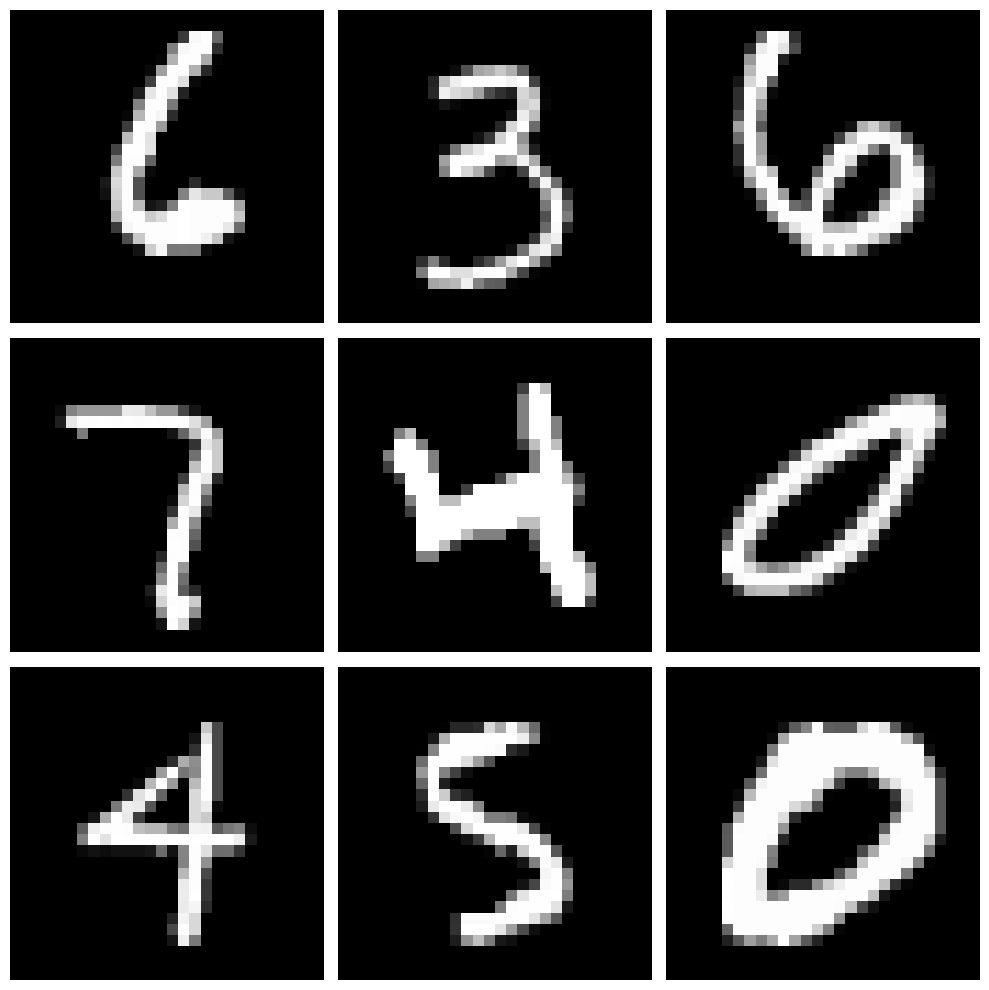

In [6]:
def get_dataloaders(batch_size: int = 128, num_workers=0):
    #transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((1,), (1,))])
    transform = transforms.Compose([transforms.ToTensor()])
    trainset = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
    testset = datasets.MNIST(root="./data", train=False, download=True, transform=transform)
    val_size = int(0.2 * len(trainset))
    train_size = len(trainset) - val_size
    trainset, valset = torch.utils.data.random_split(trainset, [train_size, val_size])
    trainloader = torch.utils.data.DataLoader(
        trainset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True
    )
    valloader = torch.utils.data.DataLoader(
        valset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True
    )
    testloader = torch.utils.data.DataLoader(
        testset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True
    )
    return trainloader, valloader, testloader

# plot the images
trainloader, valloader, testloader = get_dataloaders()
images, labels = next(iter(trainloader))
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    #print(torch.min(images[i]))
    plt.imshow(images[i].squeeze(), cmap="gray")
    plt.axis("off")
plt.tight_layout()
plt.show()

In [8]:
class Flatten(nn.Module):
    def forward(self, input):
        '''
        Note that input.size(0) is usually the batch size.
        So what it does is that given any input with input.size(0) # of batches,
        will flatten to be 1 * nb_elements.
        '''
        batch_size = input.size(0)
        out = input.view(batch_size,-1)
        return out # (batch_size, *size)

In [9]:
class View(nn.Module):
    def __init__(self, shape):
        super().__init__()
        self.shape = shape

    def __repr__(self):
        return f'View{self.shape}'

    def forward(self, input):
        '''
        Reshapes the input according to the shape saved in the view data structure.
        '''
        batch_size = input.size(0)
        shape = (batch_size, *self.shape)
        out = input.view(shape)
        return out

In [47]:
class ConvAutoEncoder(nn.Module):
    def __init__(self, hidden_dim: int = 2, image_size: int = 28):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1),                     
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            
            nn.Flatten(),
            nn.Linear(32 * image_size * image_size, 256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, hidden_dim),
        )
        self.decoder = nn.Sequential(
            nn.Linear(hidden_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 256),
            nn.ReLU(),
            nn.Linear(256, 25088),
            nn.Unflatten(1, torch.Size([32, image_size, image_size])),
            
            nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.ConvTranspose2d(in_channels=16, out_channels=1, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [65]:
model = ConvAutoEncoder()
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
trainloader, valloader, testloader = get_dataloaders(batch_size=512, num_workers=8)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
for epoch in range(30):
    model.train()
    model.to(device)
    running_loss = 0.0
    for data in trainloader:
        inputs, _ = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        #print(torch.max(outputs), torch.max(inputs), torch.min(outputs), torch.min(inputs))
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch + 1}, Loss: {running_loss / len(trainloader)}")

Epoch 1, Loss: 0.25141624361276627
Epoch 2, Loss: 0.2057911515869993
Epoch 3, Loss: 0.1947546531545355
Epoch 4, Loss: 0.1893801341982598
Epoch 5, Loss: 0.18594336937716666
Epoch 6, Loss: 0.18423950577035864
Epoch 7, Loss: 0.18225612047504872
Epoch 8, Loss: 0.1806703564968515


KeyboardInterrupt: 

In [32]:
with torch.no_grad():
    images, _ = next(iter(trainloader))
    images = images.to(device)
    outputs = model(images)

    # Plot original and reconstructed images
    plt.figure(figsize=(10, 5))
    for i in range(10):
        plt.subplot(2, 10, i + 1)
        plt.imshow(images[i].reshape(28, 28).detach().cpu(), cmap='gray')
        plt.subplot(2, 10, i + 11)
        plt.imshow(outputs[i].reshape(28, 28).detach().cpu(), cmap='gray')
    plt.show()

/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


TypeError: Value after * must be an iterable, not int

## Вариативные автоэнкодеры (35%)

![img](https://www.researchgate.net/publication/365190062/figure/fig2/AS:11431281095388874@1667878234857/Structure-of-the-conditional-variational-autoencoder-CVAE.png)

Воспользуйтесь кодом из семинара (либо конволюционными автоэнкодером из прошого задания) и добавьте условия на вариативные автоэнкодеры.

1. В качестве условия используйте метки классов.
2. В энкодер и декодер добавьте условия на метки классов.


Проверьте качество модели и сравните с обычным вариативным автоэнкодером.

In [20]:
class VariationalAutoEncoder(nn.Module):
    def __init__(self, hidden_dim: int = 2, num_classes: int = 10, image_size: int = 28):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_classes = num_classes
        self.image_size = 28
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        self.label_emb = nn.Embedding(num_classes, num_classes)
        
        # encoder part
        self.encode1 = nn.Linear(self.image_size * self.image_size + self.num_classes, 512)
        self.encode2 = nn.Linear(512, 256)
        self.encode_mu = nn.Linear(256, self.hidden_dim)
        self.encode_logvar = nn.Linear(256, self.hidden_dim)
        # decoder part
        self.decode1 = nn.Linear(self.hidden_dim, 256)
        self.decode2 = nn.Linear(256, 512)
        self.decode3 = nn.Linear(512, 28 * 28)

    def encoder(self, x, y):
        
        c = self.label_emb(y)
        
        h = F.relu(self.encode1(torch.cat([x, c]), 1))
        h = F.relu(self.encode2(h))
        return self.encode_mu(h), self.encode_logvar(h)

    def sampling(self, mu, log_var):
        std = torch.exp(0.5 * log_var)  # logvar -> std
        eps = torch.randn_like(std)  # noise
        return mu + eps * std

    def decoder(self, z):
        h = F.relu(self.decode1(z))
        h = F.relu(self.decode2(h))
        return torch.tanh(self.decode3(h))

    def forward(self, x, y):
        mu, log_var = self.encoder(x.view(-1, self.image_size * self.image_size), y)
        z = self.sampling(mu, log_var)
        return self.decoder(z), mu, log_var

    def generate(self, num_samples):
        z = torch.randn(num_samples, self.hidden_dim, device=self.device)
        return self.decoder(z)


def loss_function(recon_x, x, mu, log_var):
    BCE = F.mse_loss(recon_x, x.view(-1, 784), reduction="sum")
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return BCE + KLD

In [21]:
num_classes = 10
embedding_dims=5
model = VariationalAutoEncoder(hidden_dim=5, num_classes=num_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
trainloader, valloader, testloader = get_dataloaders(batch_size=512, num_workers=8)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
embed_cond = nn.Embedding(num_embeddings=num_classes,
                                       embedding_dim=embedding_dims,
                                       max_norm=True)
for epoch in range(100):
    model.train()
    model.to(device)
    running_loss = 0.0
    for data in trainloader:
        inputs, labels = data[0].to(device), data[1].to(device)
        #labels_emb = embed_cond(labels)
        #labels_oh = torch.nn.functional.one_hot(labels, num_classes=num_classes)
        #print(inputs, labels, labels_oh, embed_cond)
        optimizer.zero_grad()
        outputs, mu, logsigma = model(inputs, labels)
        #outputs, mu, logsigma = model(torch.cat((inputs, labels_emb), dim=1))
        
        loss = loss_function(outputs, inputs, mu, logsigma)
        
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch + 1}, Loss: {running_loss / len(trainloader)}")

/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


RuntimeError: Sizes of tensors must match except in dimension 0. Expected size 784 but got size 10 for tensor number 1 in the list.

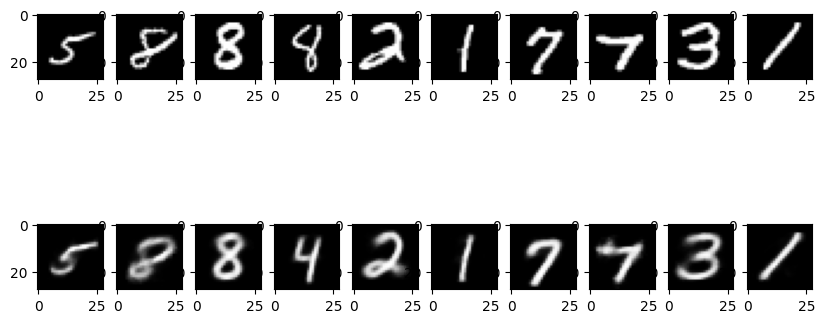

In [ ]:
import matplotlib.pyplot as plt

with torch.no_grad():
    images, _ = next(iter(trainloader))
    images = images.to("cuda")
    outputs = model(images)

    plt.figure(figsize=(10, 5))
    for i in range(10):
        plt.subplot(2, 10, i + 1)
        plt.imshow(images[i].reshape(28, 28).detach().cpu(), cmap='gray')
        plt.subplot(2, 10, i + 11)
        plt.imshow(outputs[0][i].reshape(28, 28).detach().cpu(), cmap='gray')
    plt.show()


## GAN с условием (35%)

Воспользуйтесь кодом из семинара и добавьте условия на GAN модели.

1. В качестве условия используйте метки классов.
2. В генератор и дискриминатор добавьте условия на метки классов.

Проверьте качество модели и сравните с остальными моделями. Какую модель вы бы выбрали для работы с генерацией картинок MNIST и почему?

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

class Generator(nn.Module):
    def __init__(self, input_dim:int=100, hidden_dim:int=256, output_dim:int=28 * 28):
        super().__init__()
        self.main = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, hidden_dim * 2),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim * 2, output_dim),
            nn.Tanh(),
        )

    def forward(self, noise):
        return self.main(noise).view(-1, 1, 28, 28)


class Discriminator(nn.Module):
    def __init__(self, input_dim:int=28 * 28, hidden_dim:int=512):
        super().__init__()
        self.main = nn.Sequential(
            nn.Linear(input_dim, hidden_dim * 2),
            nn.LeakyReLU(0.2),  # LeakyReLU is common in GANs
            nn.Dropout(0.5),  # Dropout for regularization
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.5),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid(),  # Output probability of real/fake
        )

    def forward(self, image:torch.Tensor):
        return self.main(image.view(-1, 28 * 28))  # Flatten input

Epoch [10/200], D_Loss: 0.7308, G_Loss: 1.5052

Epoch [20/200], D_Loss: 0.8992, G_Loss: 3.2735

Epoch [30/200], D_Loss: 0.8326, G_Loss: 2.2380

Epoch [40/200], D_Loss: 0.9813, G_Loss: 1.1887

Epoch [50/200], D_Loss: 1.0990, G_Loss: 1.0996

Epoch [60/200], D_Loss: 1.1985, G_Loss: 1.1657

Epoch [70/200], D_Loss: 1.1959, G_Loss: 0.9029

Epoch [80/200], D_Loss: 1.2335, G_Loss: 0.9627

Epoch [90/200], D_Loss: 1.2301, G_Loss: 0.7704

Epoch [100/200], D_Loss: 1.2372, G_Loss: 0.9484

Epoch [110/200], D_Loss: 1.2305, G_Loss: 0.7912

Epoch [120/200], D_Loss: 1.2527, G_Loss: 0.8796

Epoch [130/200], D_Loss: 1.2492, G_Loss: 0.9815

Epoch [140/200], D_Loss: 1.2758, G_Loss: 0.9235

Epoch [150/200], D_Loss: 1.2643, G_Loss: 0.9456

Epoch [160/200], D_Loss: 1.2453, G_Loss: 0.8573

Epoch [170/200], D_Loss: 1.2727, G_Loss: 0.7754

Epoch [180/200], D_Loss: 1.2578, G_Loss: 0.9130

Epoch [190/200], D_Loss: 1.2570, G_Loss: 1.0313

Epoch [200/200], D_Loss: 1.2926, G_Loss: 0.8955


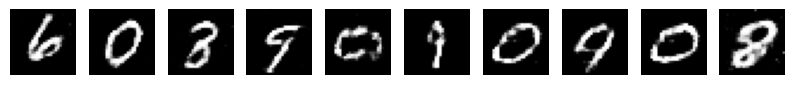

In [ ]:
generator = Generator().to("cuda")
discriminator = Discriminator().to("cuda")
criterion = nn.BCELoss()

# возможно стоит поиграть с гиперпараметрами
optimizer_G = optim.Adam(generator.parameters(), lr=0.0003, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0001, betas=(0.5, 0.999))

EPOCHS = 200
for epoch in range(EPOCHS):
    for real_images, _ in trainloader:
        real_images = real_images.to("cuda")
        batch_size = real_images.size(0)

        # Train Discriminator
        optimizer_D.zero_grad()
        real_labels = torch.ones(batch_size, 1).to("cuda")
        fake_labels = torch.zeros(batch_size, 1).to("cuda")

        real_output = discriminator(real_images)
        d_loss_real = criterion(real_output, real_labels)
        d_loss_real.backward()

        noise = torch.randn(batch_size, 100).to("cuda")
        fake_images = generator(noise)
        fake_output = discriminator(fake_images.detach())
        d_loss_fake = criterion(fake_output, fake_labels)
        d_loss_fake.backward()
        optimizer_D.step()

        # Train Generator
        optimizer_G.zero_grad()
        fake_output = discriminator(fake_images)
        g_loss = criterion(fake_output, real_labels)
        g_loss.backward()
        optimizer_G.step()
    if (epoch + 1) % 10 == 0:
        print(
            f"Epoch [{epoch+1}/{EPOCHS}], D_Loss: {d_loss_real.item() + d_loss_fake.item():.4f}, G_Loss: {g_loss.item():.4f}"
        )

In [ ]:

z = torch.randn(10, 100).to("cuda")
with torch.no_grad():
    fake_images = generator(z).detach().cpu()
plt.figure(figsize=(10, 2))
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.imshow(fake_images[i][0], cmap="gray")
    plt.axis("off")
plt.show()

## Решил ДЗ - дай обратную связь ;)

Надеемся, было интересно и полезно.

Пожалуйста, оставьте обратную связь по этому домашнему заданию: https://forms.gle/iY5NRn9UfaZ344rbA